In [2]:
!git clone https://github.com/softwareWCU/Data-Preprocessing-for-ML-using-Titanic-Dataset.git
%cd Data-Preprocessing-for-ML-using-Titanic-Dataset
!ls


Cloning into 'Data-Preprocessing-for-ML-using-Titanic-Dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 2.63 MiB | 13.21 MiB/s, done.
/content/Data-Preprocessing-for-ML-using-Titanic-Dataset
Machine_Learning.ipynb	README.md  titanic2.csv


In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [31]:
!git config --global user.name "tedolight"
!git config --global user.email "tedit3833@gmail.com"


In [32]:
%cd /content/Data-Preprocessing-for-ML-using-Titanic-Dataset
!ls


/content/Data-Preprocessing-for-ML-using-Titanic-Dataset
Machine_Learning.ipynb	README.md  titanic2.csv  titanic_knn_outputs


In [33]:
!cp /content/titanic_knn_visualized.ipynb .


cp: cannot stat '/content/titanic_knn_visualized.ipynb': No such file or directory


In [34]:
!pwd
!ls


/content/Data-Preprocessing-for-ML-using-Titanic-Dataset
Machine_Learning.ipynb	README.md  titanic2.csv  titanic_knn_outputs


In [4]:
INPUT_PATH = "titanic2.csv"   # change if needed
OUT_DIR = "titanic_knn_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [5]:
df = pd.read_csv(INPUT_PATH)
print("Loaded dataset shape:", df.shape)
print(df.head())

Loaded dataset shape: (909, 12)
   PassengerId  Survived Pclass  \
0            1         0      3   
1            2         1      1   
2            3         1      3   
3            4         1      1   
4            5         0      3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  Female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   

In [6]:
# ---------- Basic Feature Engineering ----------
data = df.copy()

In [7]:
# Drop obviously noisy columns (optional)
for c in ['PassengerId', 'Ticket']:
    if c in data.columns:
        data.drop(columns=[c], inplace=True)

In [8]:
# Extract Title from Name -> map rare titles to 'Other'
def extract_title(name):
    if pd.isnull(name): return "Unknown"
    parts = name.split(',')
    if len(parts) > 1:
        return parts[1].split('.')[0].strip()
    return "Unknown"

if 'Name' in data.columns:
    data['Title'] = data['Name'].apply(extract_title)
    data.drop(columns=['Name'], inplace=True)
    data['Title'] = data['Title'].map(lambda t: t if t in ['Mr','Mrs','Miss','Master'] else 'Other')

In [9]:

# Extract Deck from Cabin (first letter), else 'M' for missing
if 'Cabin' in data.columns:
    data['Deck'] = data['Cabin'].apply(lambda x: x[0] if pd.notnull(x) and len(str(x))>0 else 'M')
    data.drop(columns=['Cabin'], inplace=True)

# Family features
if 'SibSp' in data.columns and 'Parch' in data.columns:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

In [10]:
# Embarked fill
if 'Embarked' in data.columns:
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

In [11]:

# Fare: fillna median and create quartile bin
if 'Fare' in data.columns:
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    try:
        data['FareBin'] = pd.qcut(data['Fare'], 4, labels=['very_low','low','med','high'])
    except Exception:
        # fallback in case of identical fares making qcut fail
        data['FareBin'] = pd.cut(data['Fare'], bins=4, labels=['very_low','low','med','high'])


In [12]:
# Age: marker + median impute + age bins
if 'Age' in data.columns:
    data['Age_missing'] = data['Age'].isnull().astype(int)
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['AgeBin'] = pd.cut(data['Age'], bins=[0,12,18,35,60,120],
                            labels=['child','teen','young_adult','adult','senior'])

In [13]:
# Ensure target present
if 'Survived' not in data.columns:
    raise ValueError("No 'Survived' column detected in the CSV. Make sure the Titanic dataset includes the 'Survived' column.")
data['Survived'] = data['Survived'].astype(int)

In [14]:
# Save engineered CSV for inspection
engineered_path = os.path.join(OUT_DIR, "titanic_engineered.csv")
data.to_csv(engineered_path, index=False)
print("Saved engineered dataset to:", engineered_path)

Saved engineered dataset to: titanic_knn_outputs/titanic_engineered.csv


In [16]:
# ---------- Choose features ----------
numeric_features = [c for c in ['Age','Fare','FamilySize'] if c in data.columns]
categorical_features = [c for c in ['Pclass','Sex','Embarked','Title','Deck','FareBin','AgeBin'] if c in data.columns]
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

X = data[numeric_features + categorical_features]
y = data['Survived']

Numeric features: ['Age', 'Fare', 'FamilySize']
Categorical features: ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'FareBin', 'AgeBin']


In [17]:
# ---------- Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)


In [25]:
# ---------- Preprocessing pipeline ----------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# NOTE: In scikit-learn >= 1.4, 'sparse' is renamed to 'sparse_output'
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


# ---------- Model & hyperparameter search ----------
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': list(range(1, 21)),   # try 1..20
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]                          # Manhattan and Euclidean
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("GridSearch best params:", grid.best_params_)
print("CV best score:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 80 candidates, totalling 400 fits
GridSearch best params: {'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'}
CV best score: 0.8376759565422768
Test accuracy: 0.7637362637362637

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       112
           1       0.70      0.67      0.69        70

    accuracy                           0.76       182
   macro avg       0.75      0.75      0.75       182
weighted avg       0.76      0.76      0.76       182



Confusion matrix:
 [[92 20]
 [23 47]]


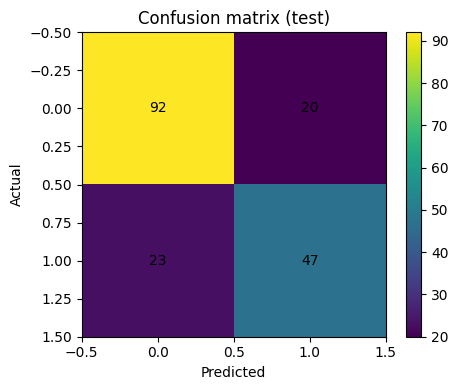

In [26]:

# ---------- Confusion matrix ----------
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix (test)")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i,j]), ha='center', va='center')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [27]:

# ---------- Permutation importance (optional, can be slower) ----------
# Transform X_test to preprocessed numeric array to pass to classifier
X_test_trans = best_model.named_steps['preprocessor'].transform(X_test)
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + ohe_feature_names

perm = permutation_importance(best_model.named_steps['classifier'],
                              X_test_trans, y_test, n_repeats=20, random_state=42, n_jobs=-1)
sorted_idx = perm.importances_mean.argsort()[::-1]
print("\nTop features (by permutation importance):")
for i in sorted_idx[:12]:
    print(f"{feature_names[i]}: mean={perm.importances_mean[i]:.4f} std={perm.importances_std[i]:.4f}")



Top features (by permutation importance):
Age: mean=0.0330 std=0.0119
FamilySize: mean=0.0308 std=0.0139
Pclass_2: mean=0.0269 std=0.0076
Sex_female: mean=0.0198 std=0.0106
Pclass_3: mean=0.0132 std=0.0094
Sex_male: mean=0.0118 std=0.0119
Title_Mr: mean=0.0113 std=0.0088
Fare: mean=0.0099 std=0.0079
Deck_C: mean=0.0088 std=0.0040
Title_Miss: mean=0.0077 std=0.0084
Deck_M: mean=0.0071 std=0.0058
Embarked_ Cherbourg: mean=0.0049 std=0.0016


In [28]:

# ---------- Cross-validated accuracy for best model on the whole dataset ----------
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("Cross-validated accuracies (5-fold):", np.round(cv_scores,4))
print("Mean CV accuracy:", cv_scores.mean())

Cross-validated accuracies (5-fold): [0.7967 0.7802 0.7857 0.8681 0.8066]
Mean CV accuracy: 0.807479813004675


In [30]:

# Save final model with joblib if desired:
try:
    import joblib
    joblib.dump(best_model, os.path.join(OUT_DIR, 'knn_pipeline.joblib'))
    print("Saved pipeline to:", os.path.join(OUT_DIR, 'knn_pipeline.joblib'))
except Exception as e:
    print("Could not save model (joblib not available?):", e)

Saved pipeline to: titanic_knn_outputs/knn_pipeline.joblib
